# Homework 3 

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Classification: forest
Classification: desert


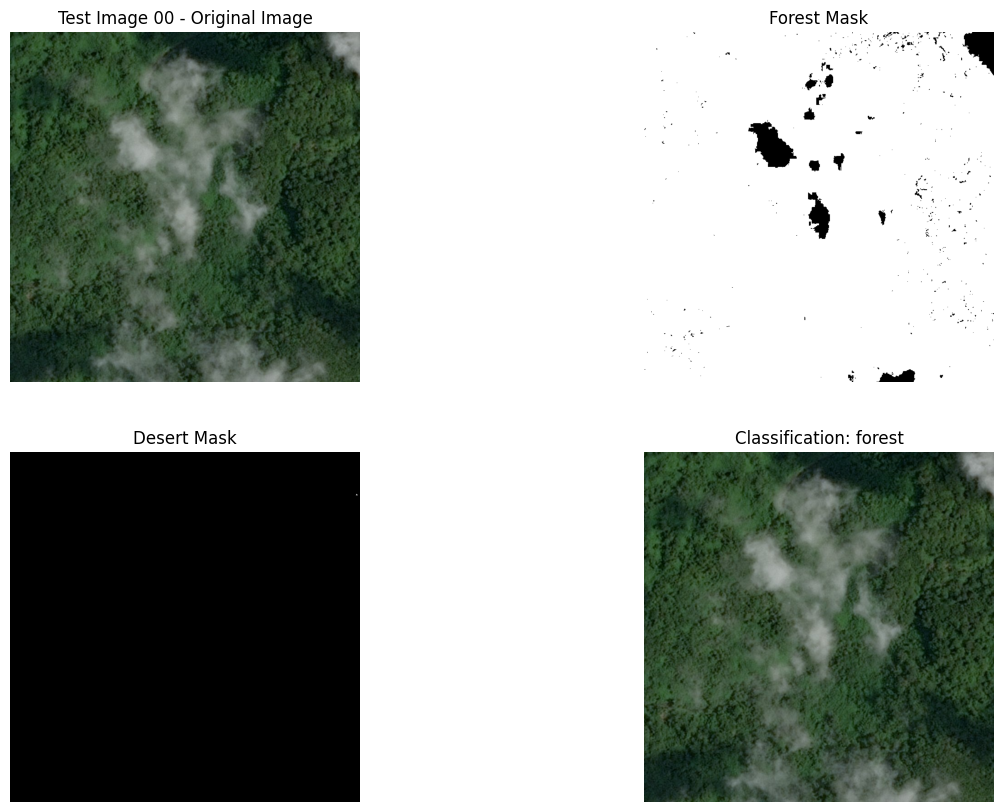

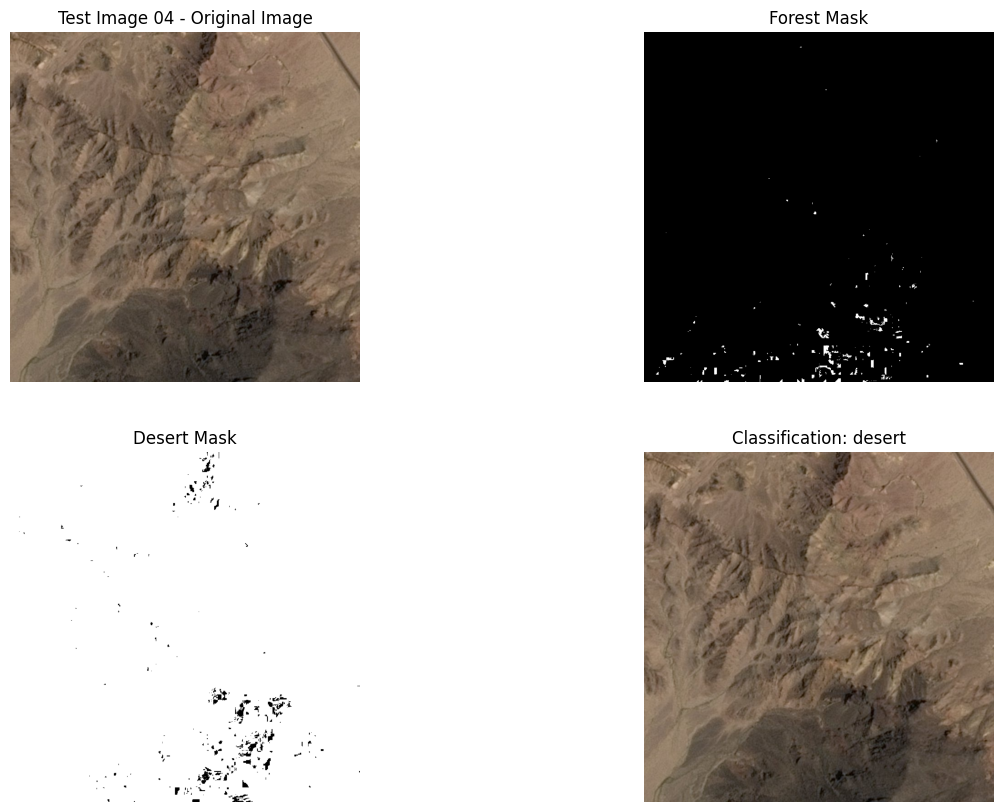

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path: str) -> np.ndarray:
    """Loads an image from the specified path."""
    image = cv2.imread(image_path)
    return image

def convert_to_hsv(image: np.ndarray) -> np.ndarray:
    """Converts the image from BGR to HSV color space."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def create_masks(hsv_image: np.ndarray) -> tuple:
    """Creates masks for forest and desert regions."""
    forest_mask = cv2.inRange(hsv_image, np.array([20, 20, 20]), np.array([100, 255, 255]))
    desert_mask = cv2.inRange(hsv_image, np.array([10, 20, 20]), np.array([30, 255, 255]))
    return forest_mask, desert_mask

def count_pixels(mask: np.ndarray) -> int:
    """Counts the number of non-zero pixels in a mask."""
    return cv2.countNonZero(mask)

def classify_scene(forest_count: int, desert_count: int) -> str:
    """Classifies the scene as either forest or desert."""
    return "forest" if forest_count > desert_count else "desert"

def classify_image(image_path: str) -> tuple:
    """Classifies an image as forest or desert."""
    image = load_image(image_path)
    hsv_image = convert_to_hsv(image)
    forest_mask, desert_mask = create_masks(hsv_image)
    forest_count = count_pixels(forest_mask)
    desert_count = count_pixels(desert_mask)
    classification = classify_scene(forest_count, desert_count)
    return classification, image, forest_mask, desert_mask

def show_images(image: np.ndarray, forest_mask: np.ndarray, desert_mask: np.ndarray, classification: str, title: str):
    """Displays the original image, masks, and classification."""
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(forest_mask, cmap='gray')
    plt.title('Forest Mask')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(desert_mask, cmap='gray')
    plt.title('Desert Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Classification: {classification}')
    plt.axis('off')

    plt.show()


# Example usage (same as before):
images_path_forest = 'desert_forest/test_image_00.jpg'
classification_forest, image_forest, forest_mask_forest, desert_mask_forest = classify_image(images_path_forest)
print(f"Classification: {classification_forest}")

images_path_desert = 'desert_forest/test_image_04.jpg'
classification_desert, image_desert, forest_mask_desert, desert_mask_desert = classify_image(images_path_desert)
print(f"Classification: {classification_desert}")

show_images(image_forest, forest_mask_forest, desert_mask_forest, classification_forest, 'Test Image 00')
show_images(image_desert, forest_mask_desert, desert_mask_desert, classification_desert, 'Test Image 04')

# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="../homework/blending/blending.png" alt="Drawing" style="width: 700px;"/>


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Загружаем каскады Хаара для распознавания лиц и их частей
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
nose_cascade = cv2.CascadeClassifier('haar/haarcascade_mcs_nose.xml')  
mouth_cascade = cv2.CascadeClassifier('haar/haarcascade_mcs_mouth.xml')  

# Проверка корректности загрузки каскадов
if any(cascade.empty() for cascade in [face_cascade, eye_cascade, nose_cascade, mouth_cascade]):
    raise ValueError('Ошибка при загрузке каскадов Хаара')

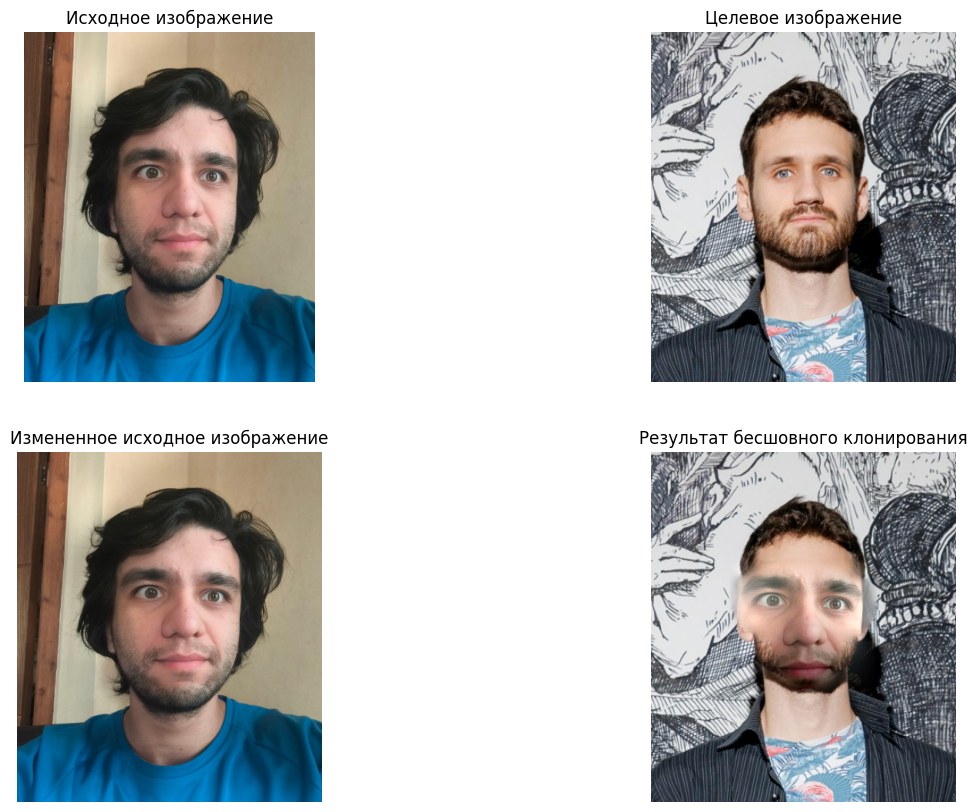

True

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load cascade classifiers (replace with your actual paths)
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
# nose_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_mcs_nose.xml')
# mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')


def load_image(image_path: str) -> np.ndarray:
    """Loads an image from the specified path, raises ValueError if loading fails."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from: {image_path}")
    return img

def to_grayscale(image: np.ndarray) -> np.ndarray:
    """Converts an image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def detect_features(gray_image: np.ndarray, cascade: cv2.CascadeClassifier) -> list:
    """Detects features (faces, eyes, etc.) using a Haar cascade."""
    return cascade.detectMultiScale(gray_image, scaleFactor=2.5, minNeighbors=5)

def create_feature_mask(gray_image: np.ndarray, detected_faces: list, eye_cascade: cv2.CascadeClassifier, nose_cascade: cv2.CascadeClassifier, mouth_cascade: cv2.CascadeClassifier) -> np.ndarray:
    """Creates a mask highlighting detected facial features."""
    mask = np.zeros_like(gray_image)
    for (x, y, w, h) in detected_faces:
        roi_gray = gray_image[y:y+h, x:x+w]
        #Eyes
        eyes = detect_features(roi_gray, eye_cascade)
        for (ex, ey, ew, eh) in eyes:
            cv2.ellipse(mask, ((ex + ew//2 + x), (ey + eh//2 + y)), (ew*1, eh*1), 0, 0, 360, 255, -1)
        #Nose
        nose = detect_features(roi_gray, nose_cascade)
        for (nx, ny, nw, nh) in nose:
            cv2.ellipse(mask, ((nx + nw//2 + x), (ny + nh//3 + y)), (nw*1, nh*2), 0, 0, 360, 255, -1)
        #Mouth
        mouth = detect_features(roi_gray, mouth_cascade)
        for (mx, my, mw, mh) in mouth:
            cv2.ellipse(mask, ((mx + mw//2 + x), (my + mh//2 + y)), (mw*1, mh*1), 0, 0, 360, 255, -1)
    return mask

def resize_image(image: np.ndarray, width: int, height: int) -> np.ndarray:
    """Resizes an image to the specified dimensions."""
    return cv2.resize(image, (width, height))

def perform_seamless_cloning(source_image: np.ndarray, target_image: np.ndarray, mask: np.ndarray, center: tuple) -> np.ndarray:
    """Performs seamless cloning using the specified parameters."""
    return cv2.seamlessClone(source_image, target_image, mask, center, cv2.NORMAL_CLONE)


#Main part of the code
source_image = load_image("faces/face_2.jpg")
target_image = load_image("faces/face_1.jpg")

gray_source = to_grayscale(source_image)
gray_target = to_grayscale(target_image)

faces_source = detect_features(gray_source, face_cascade)
faces_target = detect_features(gray_target, face_cascade)


source_mask = create_feature_mask(gray_source, faces_source, eye_cascade, nose_cascade, mouth_cascade)
target_mask = create_feature_mask(gray_target, faces_target, eye_cascade, nose_cascade, mouth_cascade)

target_height = target_image.shape[0]
target_width = target_image.shape[1]

resized_source = resize_image(source_image, target_width, target_height)
resized_source_mask = resize_image(source_mask, target_width, target_height)

clone_center = (int(target_width / 2), int(target_height / 2))

final_image = perform_seamless_cloning(resized_source, target_image, resized_source_mask, clone_center)


# Display and save results (matplotlib part remains the same)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
plt.title('Целевое изображение')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(resized_source, cv2.COLOR_BGR2RGB))
plt.title('Измененное исходное изображение')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title('Результат бесшовного клонирования')
plt.axis('off')

plt.show()

cv2.imwrite('seamless_cloned_image.jpg', final_image)


# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

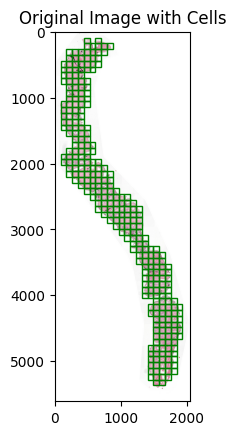

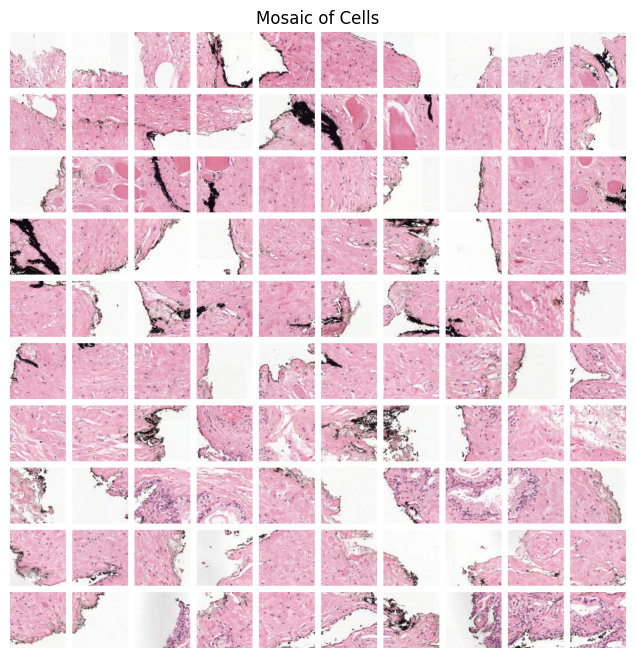

In [64]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches

def load_image(image_filepath: str) -> np.ndarray:
    """Loads image from filepath and converts to NumPy array."""
    img = Image.open(image_filepath)
    return np.array(img)

def get_image_dimensions(image_array: np.ndarray) -> tuple:
    """Returns (height, width) of the image."""
    return image_array.shape[:2]

def extract_cells(image_array: np.ndarray, cell_dim: int, max_cells: int) -> tuple:
    """Extracts cells and returns them along with bounding boxes for display."""
    height, width = get_image_dimensions(image_array)
    extracted_cells = []
    bounding_boxes = []
    total_cells_extracted = 0
    for y in range(0, height, cell_dim):
        for x in range(0, width, cell_dim):
            if total_cells_extracted >= max_cells:
                break
            cell = image_array[y:y + cell_dim, x:x + cell_dim]
            if cell.mean() < 240:  # Threshold for filtering empty areas
                extracted_cells.append(cell)
                bounding_boxes.append((x, y, cell_dim, cell_dim))
                total_cells_extracted += 1
    return extracted_cells, bounding_boxes

def display_image_with_cells(image_array: np.ndarray, bounding_boxes: list):
    """Displays image with bounding boxes."""
    _, ax = plt.subplots(1)
    ax.imshow(image_array)
    for x, y, w, h in bounding_boxes:
        rectangle = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rectangle)
    plt.title("Original Image with Cells")
    plt.show()

def create_mosaic(extracted_cells: list, cell_dim: int, space: int, grid_size: int = 10) -> np.ndarray:
    """Creates mosaic image."""
    extracted_cells = handle_cell_count(extracted_cells, grid_size * grid_size)  #Adjust for grid size
    mosaic_dimensions = grid_size * cell_dim + (grid_size - 1) * space
    mosaic_image = np.ones((mosaic_dimensions, mosaic_dimensions, 3), dtype=np.uint8) * 255
    for index, cell in enumerate(extracted_cells):
        row = index // grid_size
        col = index % grid_size
        y_start = row * (cell_dim + space)
        x_start = col * (cell_dim + space)
        mosaic_image[y_start:y_start + cell_dim, x_start:x_start + cell_dim] = cell
    return mosaic_image

def handle_cell_count(extracted_cells: list, desired_count: int) -> list:
    """Handles cell count for mosaic."""
    if len(extracted_cells) > desired_count:
        return extracted_cells[:desired_count]
    elif len(extracted_cells) < desired_count:
        return extracted_cells * (desired_count // len(extracted_cells)) + extracted_cells[:desired_count % len(extracted_cells)]
    return extracted_cells

def display_mosaic(mosaic_image: np.ndarray):
    """Displays mosaic."""
    plt.figure(figsize=(8, 8))
    plt.imshow(mosaic_image)
    plt.axis('off')
    plt.title("Mosaic of Cells")
    plt.show()


def display_and_extract_cells(image_filepath: str, cell_dim: int, max_cells: int, space: int = 10):
    """Main function."""
    image_array = load_image(image_filepath)
    extracted_cells, bounding_boxes = extract_cells(image_array, cell_dim, max_cells)
    display_image_with_cells(image_array, bounding_boxes)
    mosaic_image = create_mosaic(extracted_cells, cell_dim, space)
    display_mosaic(mosaic_image)

# Вызов функции с путь к изображению
display_and_extract_cells("cells/train5_1.jpeg", cell_dim=88, max_cells=305)